# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2024

Мягкий дедлайн: 22.12.2024 23:59 MSK

Жёсткий дедлайн: 22.12.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице


Максимальная оценка: 10

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность, так что заодно научимся, как его правильно готовить

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

sns.set(style='darkgrid')
filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
X = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

X_train.shape, X_valid.shape, X_test.shape

((18825, 169), (2354, 169), (2353, 169))

---

## Задание 1. Базовый градиентный бустинг (4 балла)

Первая часть посвящена реализации собственного градиентного бустинга. Обращаем внимание, что пользоваться готовыми реализациями <font color='lightcoral'>**нельзя**</font>, если специально не оговорено. На все <font color='plum'>**вопросы**</font> должен быть <font color='plum'>**ответ**</font>. В заданиях есть референсы для параметров, которые нужно сделать, на случай, если объяснение из ноутбука непонятно, тогда советуем обратиться к соответствующей документации

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

Обязательные параметры:
 — `base_model_class` — класс базовой модели нашего бустинга
 — `base_model_params` — словарь с гиперпараметрами для базовой модели
 — `n_estimators` — какое количество базовых моделей нужно обучить
 — `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$

#### `fit`

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (используем `loss_fn` для этого) и найти новую оптимальную гамму

После всего цикла обучения надо нарисовать график (если `plot=True`).

#### `partial_fit`

В `partial_fit` приходит обучающая выборка, на которую обучается новая базовая модель

#### `predict_proba`

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

#### `plot_history`

В `plot_history` приходит любая выборка, для которой последовательно считаются значения функции потерь и/или любой метрики, которую вы хотите посчитать, путем последовательного применения базовых моделей. Можно делать сразу во время обучения, можно делать иначе

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

from boosting import Boosting

### Проверка кода

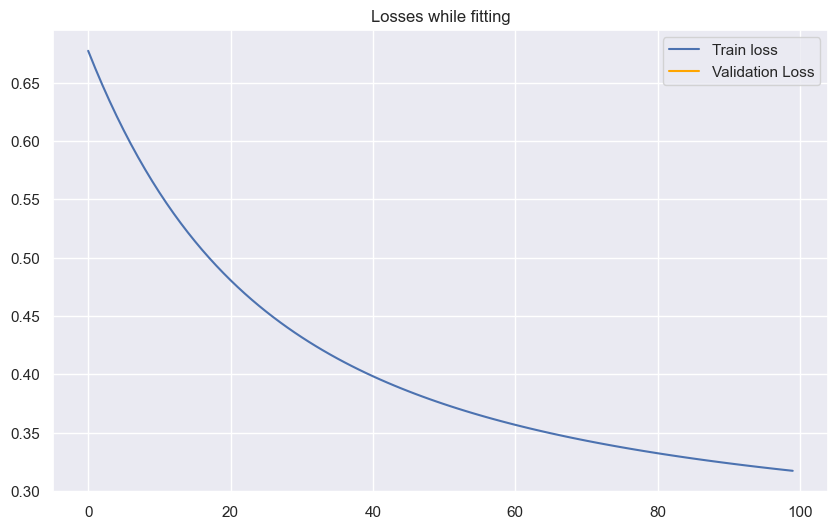

Train ROC-AUC 0.9998
Valid ROC-AUC 0.8745
Test ROC-AUC 0.8657


In [8]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

---

## Задание 2. Имплементация гиперпараметров (2.5 балла + 3.5 бонус)

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации безотносительно базовой модели. В этом пункте предлагается имплементировать часть из них. При необходимости можете обратиться к реализациям в вашей любимой библиотеке, там могут быть дополнительные пояснения и/или ссылки на оригинальные статьи

<font color='lightcoral'>**Важно!**</font> После добавления каждого параметра проверьте, как это повлияет на качество. Специально крутить параметры не нужно, но важно увидеть, что перформанс модели изменился, в худшую или в лучшую сторону, для этого какие-то параметры нужны, пусть и от балды, <font color='lightcoral'>**дефолтные параметры не подойдут**</font>, они скорее для референса. Лучше всего это видно по графикам обучения <font color='lightcoral'>**на трейне и валидации**</font>, рекомендуется смотрить именно на них

### 2.1. Борьба с переобучением (0.5 балла)

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации. Реализуйте такую процедуру, не забудьте, что всю предобработку, что вы будете делать для трейна, нужно будет повторить на валидации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| <td colspan=3>`early_stopping_rounds`, `eval_set` |

Добавьте параметры:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `X_val`, `y_val` или `eval_set: Tuple[np.ndarray] | None = None` — валидацонная выборка, на которой будем проверять переобучение

Early stopping after 19 iterations.


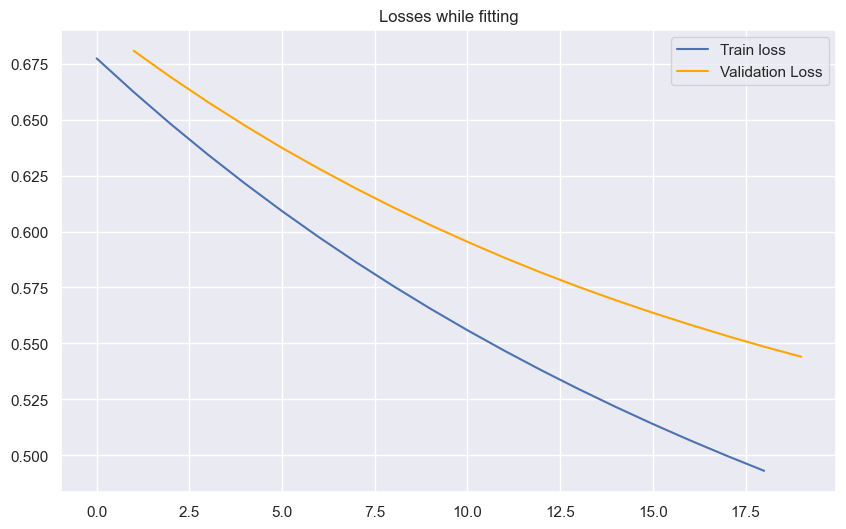

Train ROC-AUC 0.9998
Valid ROC-AUC 0.8703
Test ROC-AUC 0.8616


In [ ]:

boosting = Boosting(
    n_estimators=100,          
    early_stopping_rounds=10, 
    eval_set = [X_valid, y_valid]
)

boosting.fit(X_train, y_train, X_val=X_valid, y_val=y_valid)

boosting.plot_history(X_train, y_train)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### Бонус. Бустинг линейных моделей (0.5 балла)

**<font color='plum'>Вопрос:** что произойдет при ансамблировании линейных моделей? Имеет ли это смысл?</font>

<font color='plum'>**Ответ:** Так как бустинг обучает следующую модель на остатках предыдущей - при использовании на линейных моделях это добавляет некоторую нелинейность на каждом шаге, что может дать качество получше. В целом, ансамблирование линейных моделей как будто действительно может улучшить качество, но только в том случае, если линейная модель уже хорошо подходит для данных - то есть если есть много нелинейных зависимостей, это не даст какого то особого результата. Это происходит за счет того, что тогда небольшое число нелинейных зависимостей будет учитываться лучше (как отклонение от линейных)</font>

Давайте убедимся. Обучите бустинг, где в качестве базовой модели будет линейная регрессия. Обязательно сохраните историю функции потерь и зафиксируйте время обучения. Можно взять уже готовый из <font color='lightblue'>**XGBoost**</font>, но будьте готовы разобраться с тем, как оттуда достать историю обучения

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="gblinear")` | — | — |

In [ ]:
import time
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

eval_set = [(dtrain, 'train'), (dvalid, 'validation')]

params = {
    'booster': 'gblinear',  
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss',  
    #'learning_rate': 0.1,
    #'lambda': 1.0,  
    #'alpha': 0.0,   
    #'nthread': 4,  
    #'early_stopping_rounds': 20  
}
evals_result = {}

start_time = time.time()
model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=1000, evals=eval_set, early_stopping_rounds=10, evals_result=evals_result)
end_time = time.time()

print(f"Time: {end_time - start_time:.2f}")

[0]	train-logloss:0.40083	validation-logloss:0.41860
[1]	train-logloss:0.32402	validation-logloss:0.35618
[2]	train-logloss:0.28414	validation-logloss:0.32809
[3]	train-logloss:0.26061	validation-logloss:0.31428
[4]	train-logloss:0.24582	validation-logloss:0.30688
[5]	train-logloss:0.23640	validation-logloss:0.30339
[6]	train-logloss:0.23000	validation-logloss:0.30205
[7]	train-logloss:0.22559	validation-logloss:0.30185
[8]	train-logloss:0.22247	validation-logloss:0.30250
[9]	train-logloss:0.22017	validation-logloss:0.30341
[10]	train-logloss:0.21844	validation-logloss:0.30454
[11]	train-logloss:0.21823	validation-logloss:0.30583
[12]	train-logloss:0.21721	validation-logloss:0.30715
[13]	train-logloss:0.21640	validation-logloss:0.30864
[14]	train-logloss:0.21578	validation-logloss:0.30991
[15]	train-logloss:0.21527	validation-logloss:0.31123
[16]	train-logloss:0.21485	validation-logloss:0.31242
[17]	train-logloss:0.21451	validation-logloss:0.31350
Time: 0.03


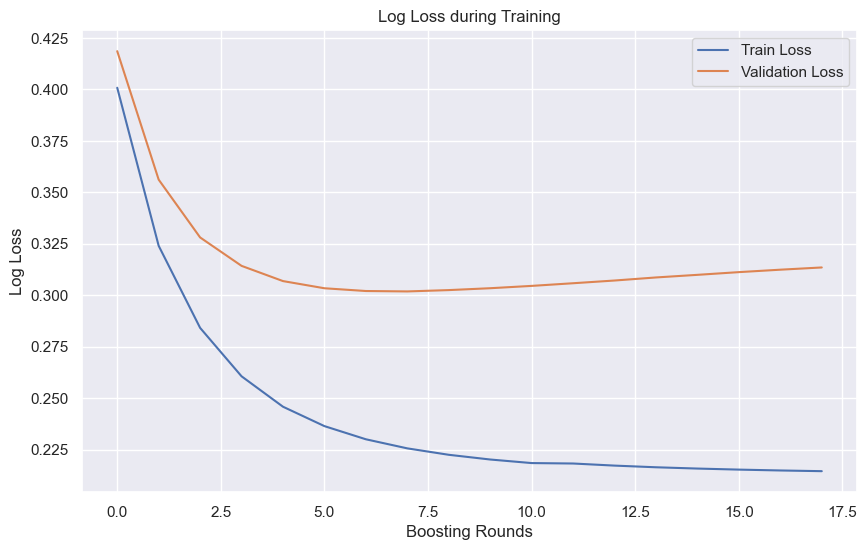

In [ ]:
train_losses = evals_result['train']['logloss']
val_losses = evals_result['validation']['logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Log Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(xgb.DMatrix(X_valid))
roc_auc = roc_auc_score(y_valid, y_pred)
print(f"ROC AUC on validation: {roc_auc:.4f}")

ROC AUC on validation: 0.9404


Теперь возьмите `sklearn.linear_model.SGDClassifier` иобучите на тех же данных. Не забудьте вытащить историю функции потерь

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

sgd_clf = SGDClassifier(
    loss="log_loss", 
    max_iter=1, 
    warm_start=True, 
    random_state=42
)

sgd_train_losses = []
sgd_val_losses = []

start_time_sgd = time.time()
for _ in range(16):  
    sgd_clf.fit(X_train, y_train)
    train_proba = sgd_clf.predict_proba(X_train)
    val_proba = sgd_clf.predict_proba(X_valid)
    sgd_train_losses.append(log_loss(y_train, train_proba))
    sgd_val_losses.append(log_loss(y_valid, val_proba))
end_time_sgd = time.time()


sgd_training_time = end_time_sgd - start_time_sgd

Покажите на одном графике изменение функции потерь для бустинга и SGD классификатора. Сравните следующие детали у бустинга и линейной модели:

- время обучения
- сходимость (как быстро, как стабильно и прочее)
- графики функции потерь на трейне и на валидации

In [ ]:
print(f"Boosting Time: {end_time - start_time:.2f} seconds")
print(f"SGDClassifier Time: {sgd_training_time:.2f} seconds")

Boosting Time: 0.03 seconds
SGDClassifier Time: 0.09 seconds


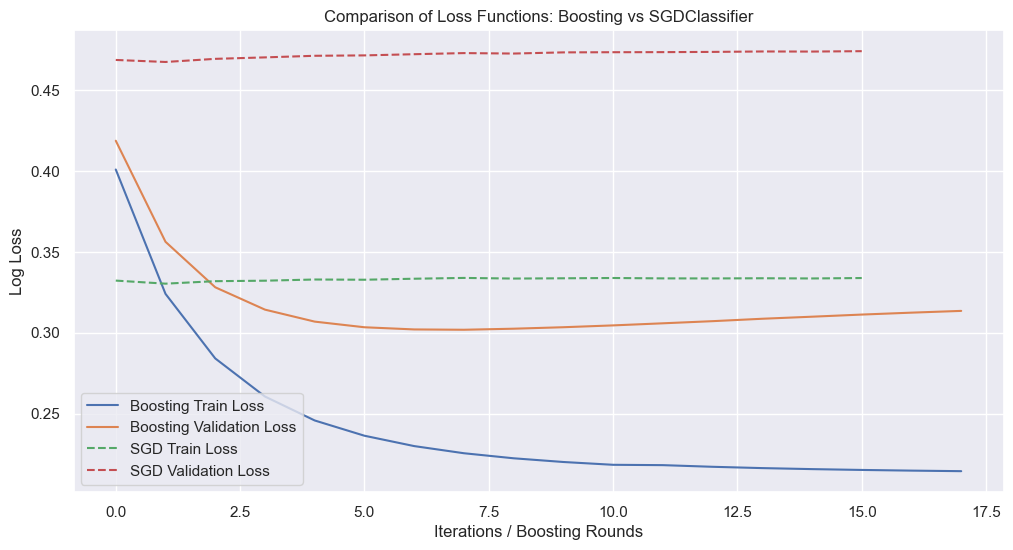

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(train_losses, label="Boosting Train Loss")
plt.plot(val_losses, label="Boosting Validation Loss")

plt.plot(sgd_train_losses, label="SGD Train Loss", linestyle='--')
plt.plot(sgd_val_losses, label="SGD Validation Loss", linestyle='--')

plt.xlabel("Iterations / Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Comparison of Loss Functions: Boosting vs SGDClassifier")
plt.legend()
plt.grid(True)
plt.show()

<font color='plum'>**Вопрос:** Какой вывод вы можете сделать?</font>

<font color='plum'>**Ответ:** По времени быстрее обучается бустинг, а не SGDClassifier (но вообще везде обучение очень быстрое) - при этом по качеству обучения он лучше, чем SGDClassifier. Оба из них сильно зависят от гиперпараметров, сходимость быстрее у SGDClassifier, но возможность это я с гиперпараметрами так и не угадала. При этом при бустинге ошибка быстрее сходится на валидационной, а дальше начинается понижение ее на обучающей за счет переобучения - у SGDClassifier такой проблемы нет  </font>

### 2.2. Бутстрап (0.5 балла)
Как известно, при обучении базовых алгоритмов в беггинге, используется бутстрапированная выборка. Звучит хайпово, почему бы не попробовать сделать то же самое в бустинге?

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `subsample`, — | `subsample`, `bagging`| `subsample`, `bootstrap_type`|

Вам нужно реализовать параметры:
- `subsample: float | int = 1.0` — доля или число объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float | int = 1.0` — веса объектов, которые попадают в выборку. Соответствует бутстрапу типа `Bayesian`. Каждый объект имеет определенный вес $t$, на который впоследствии домножается по формуле $w = (-\log(X))^t$, где $X \sim {U[0, 1]}$, после чего попадает в выборку. Таким образом можно сделать симуляцию повторений
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<font color='plum'>**Вопрос:** как бутстрап может помочь в обучении с точки зрения смещения, разброса и вообще?</font>

<font color='plum'>**Ответ:** В контексте ансамблей, бутстрап может помочь улучшить обучение и качество.

- Бутстрап сам по себе не уменьшает смещение модели. Однако, бутстрап в ансамбле моделей может компенсировать смещение отдельных слабых моделей за счет комбинирования результатов (зависит от подмножеств, на которых обучаемся)

- Помогает уменьшить разброс модели (особенно для моделей, склонных к переобучению), так как используется множество обучающих выборок, что дает более стабильные модели (предсказания становятся менее зависимыми от конкретных особенностей обучающей выборки)

- В целом, бутстрап помогает обобщать модели, так как он делает их менее чувствительными к шуму и отдельным выбросам 

Как итог, качество правда стало выше (особенно на тесте заметно)</font>

In [ ]:
boosting = Boosting(n_estimators=100, subsample=0.8, bagging_temperature=0.5, bootstrap_type='Bernoulli', bootstrap=True, eval_set=None)
boosting.fit(X_train, y_train)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

Train ROC-AUC 0.9995
Valid ROC-AUC 0.9224
Test ROC-AUC 0.9224


### Бонус. GOSS (0.5 балла)

Заметим, что во время обучения не все объекты одинаково важны. Один из вариантов это исправить — ввести какие-то веса на объекты, однако можно пойти чуть хитрее. В <font color='lightgreen'>**LightGBM**</font> придумали подход [Gradient-based One-side Sampling](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

Давайте оценивать важность объектов в отдельный момент обучения нового дерева. Будем считать, какой антиградиент привносит каждый объект. Далее разобъем градиенты на 2 группы. Объекты с большими градиентами берутся все, с маленькими — только часть, по аналогии с бутстрапом, с отрицательными — выкидываются. И не забываем домножить на фактор, чтобы учесть выкинутые объекты. Подробнее в статье

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | `bagging='goss'`| `bootstrap_type='MVS'`|

Параметры, которые нужно сделать:

- `goss: bool | None = False` — GOSS бустинг или нет
- `goss_k: float | int = 0.2` — доля объектов, градиенты которых будем считать большими. Все остальное — маленькими
- `subsample: float | int = 0.3` — параметры сэмплинга для маленьких градиентов из пункта 2.1

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 2.3. Работа с признаками (1 балл)

1. Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать `rsm`

2. С другой стороны, вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет. Для этого существует множество алгоритмов, мы предлагаем сделать два наиболее простых:

- $\text{Uniform}$. Значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- $\text{Quantile}$. Тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `colsample_bytree`, `tree_method` | `colsample_bytree`, `max_bin`| `rsm`, `quantize(...)`|

Нужно добавить параметры:
- `rsm: float | int = 1.0` — доля или число признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

<font color='plum'>**Вопрос**: как квантизация поможет в обработке выбросов и нанов?</font>

<font color='plum'>**Ответ**: квантизация, разбивая данные на несколько бинов, может помочь уменьшить влияние выбросов, так как экстремальные значения признаков (например, выбросы) будут помещены в один и тот же бин, что ограничивает их влияние на модель. Это уменьшает чрезмерную чувствительность модели к данным с большой дисперсией (а значит и переобучение). Для нанов, если квантизация делается до обучения, такие значения можно отнести к отдельной категории, создавая для них специальный бин. Или лучше обработать их до квантизации, например, заполнив их средним значением или медианой для каждого признака. </font>

<font color='plum'>**Вопрос**: можно ли просто заполнить наны каким-то числом? Имеет ли значение, что это за число (-1, -100, -1e32)?</font>

<font color='plum'>**Ответ**: можно заполнить конкретным числом: например, среднее/медиана/мода — они минимизируют искажения в распределении данных и  сохраняют данные близкими к распределению остальных признаков. Отрицательные значения (-1, -100, -1e32) — такие значения могут ввести дополнительный шум в модель, если это число не является частью логики задачи. Вероятно валидно такое использовать только в случаях, когда это соответствует данным, например, если значения признаков всегда положительные, а наны нужно заполнить минимально возможным значением.</font>

In [153]:
%autoreload 2

from boosting import Boosting

In [135]:
boosting = Boosting(n_estimators=100, quantization_type = "uniform", eval_set=None)
boosting.fit(X_train, y_train)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

Train ROC-AUC 0.5000
Valid ROC-AUC 0.5000
Test ROC-AUC 0.5000


In [126]:
boosting = Boosting(n_estimators=100, quantization_type = "quantile", eval_set=None)
boosting.fit(X_train, y_train)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

Train ROC-AUC 0.5000
Valid ROC-AUC 0.5000
Test ROC-AUC 0.5000


В общем не знаю я как это исправить, так что пусть будет так (все функции вроде добавила, неясно)

Что то объективно я не так сделала

### Бонус. Квантизация (1.5 балл)

В текущих имплементациях бустинга используются более сложные методы квантизации. К сожалению, способы выше страдают либо от неравноправности бинов — в каких-то объектов больше, в каких-то меньше, либо от того, что целевая переменная от бинов зависит опосредованно. Предлагается это исправить следующими способами:

1. $\text{MinEntropy}$. Это [один из методов](https://catboost.ai/docs/en/concepts/quantization), который используется для бинаризации в <font color='palegoldenrod'>**CatBoost**</font>, остальные на него очень похожи. Будем жадно набирать бины так, чтобы энтропия объектов внутри ($\sum_{i \in \text{bin}} x_i\log(x_i)$) была как можно меньше. Сделать такое разбиение руками непросто, но вам эта задача должна что-то напоминать
   
2. $\text{PiecewiseEncoding}$. Это относительно свежий метод для [табличных трансформеров](https://arxiv.org/pdf/2203.05556). Суть заключается в том, что бины для квантизации будем брать не с потолка, а именно те, что нужны для разбиения таргета. (В статье делается кодирование в вектор длины $T$, где $T$ число бинов, в нашем случае это излишне, бинов можно оставить столько же, но взять лмшь закодированную по формуле часть)

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | — | `feature_border_type="Piecewise"` |

Нужно добавить опцию:

- `'MinEntropy'` для `quantization_type` — какую квантизацию используем

Реализуйте оба способа подсчета (или один, но тогда балл неполный) и сравните, удалось ли улучшить качество?

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 2.4. Важность признаков (0.5 балла)

Поскольку наша базовая модель — это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными — иначе вы что-то сделали не так). Разумеется, способ не единственный, если хочется, посмотрите в документации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `model.get_score()` | `lightgbm.importance()` | `model.get_feature_importance()` |

Допишите к бустингу:
- `feature_importances_` — атрибут, который возвращает важность признаков, согласно методу выше

In [50]:
boosting = Boosting(n_estimators=100, subsample=0.8, bagging_temperature=0.5, bootstrap_type='Bernoulli', bootstrap=True, eval_set=None)
boosting.fit(X_train, y_train)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

Train ROC-AUC 0.9995
Valid ROC-AUC 0.9242
Test ROC-AUC 0.9232


Покажите, какие признаки оказались самыми важными

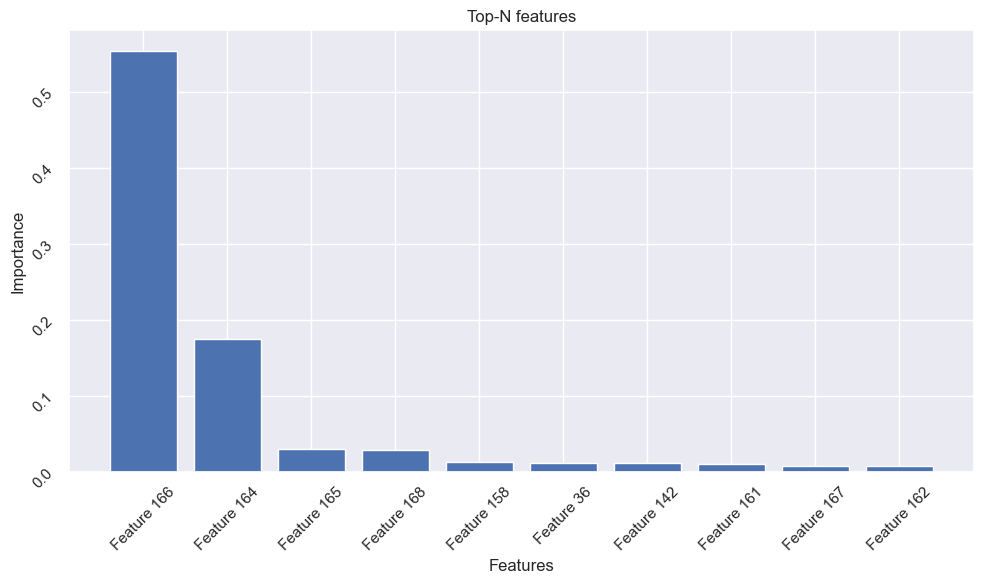

In [54]:
importances = boosting.feature_importances_()
sorted_indices = np.argsort(importances)[::-1]

N = 10  
top_N_indices = sorted_indices[:N]

plt.figure(figsize=(10, 6))
plt.bar(range(N), importances[top_N_indices], align="center")
plt.xticks(range(N), [f"Feature {i}" for i in top_N_indices])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top-N features")
plt.tick_params(labelrotation = 45)
plt.tight_layout()
plt.show()

### Бонус. DART (1.5 балла)

Ранее мы обсуждали, что каждый базовый алгоритм пытается исправить ошибки всего предыдущего ансамбля. Из-за этого возникает неравноправие — каждая новая модель вносит все меньший и меньший вклад. Уверенные обучатели нейросетей знают, что это может привести к переобучению. Но выход есть, и выход этот [DART](https://arxiv.org/pdf/1505.01866)!

В DL есть такой вид регуляризации, как dropout, когда некоторые узлы нейросети со случайным шансом отключаются. Можно попробовать обобщить этот подход на случай бустингов и случайно выкидывать деревья из композиции во время обучения

1. Выбираем, какие деревья убрать. При подсчете антиградиента берем не весь ансамбль, а только ту часть, что осталась
2. Домножаем выходы дерева на $1/k$, где $k$ — число удаленных деревьев, чтобы учесть тот факт, что ансамбль был не весь. Тогда вклад отдельного дерева будет не настолько большим
3. Домножаем выходы выкинутых деревьев на $k/(k+1)$, чтобы масштабы выходов примерно совпадали

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="dart")` | `LGBMClassifier(boosting_type="dart")` | — |

Параметры, которые нужно добавить:

- `dart: bool | None = False` — DART бустинг или нет
- `dropout_rate: int | float = 0.05` — доля деревьев, которую выкидываем во время обучения DART

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

------

## Задание 3. Оптимизация (3.5 балла + 0.5 бонус)

Теперь давайте подумаем, как же правильно применять бустинги. Нас интересует: какие бустинги вообще бывают, как их правильно тюнить, и как интерпретировать

Оптимизация моделей с большим числом гиперпараметров это сложное дело. Нетрудно догадаться, что в случае, когда параметров $m$, сложность перебора в самом худшем случае будет порядка $n^m$. У бустингов, хотя на самом деле не только, эта проблема стоит особенно остро. Подумаем, как это делать умнее

### 3.1. Знакомство с optuna (1 балл)

Для эффективного подбора гиперпараметров существует несколько решений, основанных на байесовской оптимизации. В этом задании предлагается познакомиться с библиотекой [optuna](https://optuna.org/), которая делает перебор гиперпараметров легким и приятным, а также сохраняет всю историю экспериментов в одно место за вас

Подберите на валидации оптимальные значения следующих гиперпараметров для вашей реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`
- любые другие параметры, которые вам понравились

Заметим, что оптуна это крайне гибкая библиотека, в которой можно реализовать абсолютно любую логику, которую пожелаете. За вас там есть лишь выбор модели. Чтобы не плодить несколько `objective`, можно слегка менять тело функции, например, добавить опциональные параметры, но шаблоном пользоваться не обязательно, как обычно

Подберите диапазон параметров самостоятельно, не забывайте фиксировать сид (нет, его не нужно перебирать). Сохраните и покажите оптимальный набор параметров. Сравните графики функций потерь для оптимального и дефолтного бустингов. Покажите, какие параметры дали наибольший прирост (для этого придется почитать документацию оптуны)

In [56]:
import optuna

def objective(study, model="custom_boosting"):
    # параметры, общие для всех бустингов
    common_params = ...
    # параметры для конкретной имплементации бустинга
    optional_params = ...

    pass

In [106]:
val_loss_history = {}

def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 500) 
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)  
    subsample = trial.suggest_float("subsample", 0.5, 1.0)  
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 13, step=2)
    min_samples_split = trial.suggest_int('tree_min_samples_split', 5, 30, step=3)

    model = Boosting(
        base_model_params={"max_depth": max_depth, "min_samples_split": min_samples_split},
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        bootstrap = True
    )
    
    model.fit(X_train, y_train, X_valid, y_valid)
    
    val_predictions = model.predict_proba(X_valid)[:, 1]
    val_auc = roc_auc_score(y_valid, val_predictions)
   
    return val_auc 


study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=40) 

[I 2024-12-22 19:22:20,446] A new study created in memory with name: no-name-19bea8e5-e513-440a-88a7-457199ed72ca
[I 2024-12-22 19:22:29,407] Trial 0 finished with value: 0.9097844644896806 and parameters: {'max_depth': 9, 'n_estimators': 250, 'learning_rate': 0.058203879130355525, 'subsample': 0.6486014524904227, 'early_stopping_rounds': 13, 'tree_min_samples_split': 29}. Best is trial 0 with value: 0.9097844644896806.
[I 2024-12-22 19:22:33,306] Trial 1 finished with value: 0.8801999149128416 and parameters: {'max_depth': 2, 'n_estimators': 149, 'learning_rate': 0.15503372135598242, 'subsample': 0.9434665917030598, 'early_stopping_rounds': 13, 'tree_min_samples_split': 23}. Best is trial 0 with value: 0.9097844644896806.
[I 2024-12-22 19:22:53,632] Trial 2 finished with value: 0.9105698844139642 and parameters: {'max_depth': 10, 'n_estimators': 349, 'learning_rate': 0.47011151720563815, 'subsample': 0.8833911567507955, 'early_stopping_rounds': 13, 'tree_min_samples_split': 14}. Best 

In [107]:
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best ROC AUC score: {study.best_value}")

Best parameters: {'max_depth': 10, 'n_estimators': 83, 'learning_rate': 0.48493492197451943, 'subsample': 0.732655797277864, 'early_stopping_rounds': 7, 'tree_min_samples_split': 14}
Best ROC AUC score: 0.9390485403880645


In [99]:
default_model = Boosting(
    n_estimators=100,
    early_stopping_rounds=10,
    bootstrap=True
)
default_model.fit(X_train, y_train, X_valid, y_valid)

In [111]:
best_trial = study.best_trial
default_model.eval_set = (X_valid, y_valid)
default_val_loss_history = default_model.get_losses()

best_boosting = Boosting(n_estimators=study.best_params["n_estimators"],
                    learning_rate=study.best_params["learning_rate"],
                    subsample=study.best_params["subsample"],
                    early_stopping_rounds=study.best_params["early_stopping_rounds"],
                    eval_set = (X_valid, y_valid),
                    base_model_params= {
                      'max_depth': study.best_params['max_depth'],
                      'min_samples_split': study.best_params['tree_min_samples_split']
                    })

best_boosting.fit(X_train, y_train, X_valid, y_valid)
val_loss_history = best_boosting.get_losses()

Early stopping after 16 iterations.


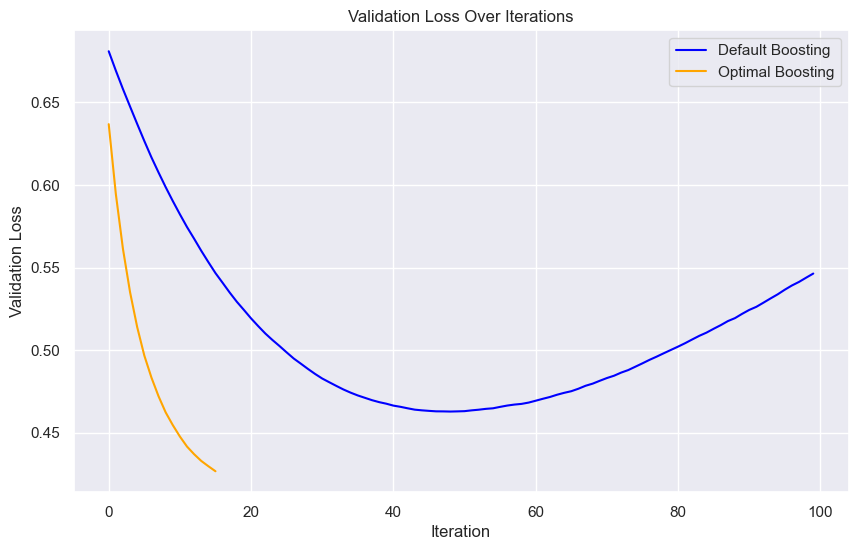

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(default_val_loss_history, label="Default Boosting", color="blue")
plt.plot(val_loss_history, label="Optimal Boosting", color="orange")
plt.title("Validation Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

In [113]:
import optuna.visualization as vis

vis.plot_param_importances(study).show()

In [114]:
vis.plot_slice(study).show()

### 3.2. Глубокая оптимизация (1 балл)

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения. Улучшите процедуру оптимизации следующим образом:

1. Посмотрите, как в `optuna` устроена запись в хранилища, и добавьте это в пайплайн оптимизации. Без указания БД все запуски оптуны сотрутся, как только закончится сессия. Более того, так можно распараллелить процесс оптимизации на несколько машин
2. Посмотрите, как можно контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые, их можно использовать пунктом ниже. Для кастомной модели возьмите что-то из `optuna.pruners`. Идея прунера — не обучать бустинг до конца, если по истории видно, что другие бустинги на этом этапе статистически лучше.
3. Добавьте сохранение истории функции потерь и времени обучения в качестве `user_attribute` сразу в `study`. Мы не хотим оптимизировать их напрямую, но они нам понадобится для сравнения моделей в дальнейшем

Добавьте хранилище и юзер атрибуты и посмотрите, ускорилась ли оптимизация с добавлением прунера

In [ ]:
%autoreload 2

from boosting import Boosting

In [155]:
from optuna.pruners import MedianPruner 
import time

study = optuna.create_study(
    study_name="boosting_optimization",
    storage="sqlite:///my_optuna.db",    
    load_if_exists=True,                 
    direction="maximize",
    pruner=MedianPruner(n_warmup_steps=5) 
)

def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 13, step=2)
    min_samples_split = trial.suggest_int('tree_min_samples_split', 5, 30, step=3)

    model = Boosting(
        base_model_params={"max_depth": max_depth, "min_samples_split": min_samples_split},
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        bootstrap=True,
        early_stopping_rounds=early_stopping_rounds,
        eval_set=(X_valid, y_valid)
    )
    
    start_time = time.time()

    train_predictions = np.zeros_like(y_train, dtype=float)
    best_val_score = -np.inf
    rounds_without_improvement = 0

    for i in range(n_estimators):
        if model.bootstrap:
            X_sample, y_sample = model.bootstrap_sample(X_train, y_train)
            if train_predictions.shape[0] != y_sample.shape[0]:
                train_predictions = np.zeros(y_sample.shape[0])
        else:
            X_sample, y_sample = X_train, y_train

        X_sample = model._quantize_features(X_sample)
        new_predictions = model.partial_fit(X_sample, y_sample, train_predictions)
        train_predictions += model.learning_rate * model.gammas[-1] * new_predictions

        train_loss = model.loss_fn(y_sample, train_predictions)
        train_auc = roc_auc_score(y_sample, model.sigmoid(train_predictions))
        model.history["train_loss"].append(train_loss)
        model.history["train_roc_auc"].append(train_auc)

        val_preds = model.predict_proba(X_valid)[:, 1]
        val_auc = roc_auc_score(y_valid, val_preds)
        model.history["val_roc_auc"].append(val_auc)

        if val_auc > best_val_score:
            best_val_score = val_auc
            rounds_without_improvement = 0
        else:
            rounds_without_improvement += 1
        if rounds_without_improvement >= early_stopping_rounds:
            break

        trial.report(val_auc, i)     
        if trial.should_prune():
            raise optuna.TrialPruned()

    end_time = time.time()

    trial.set_user_attr("train_loss_history", model.history["train_loss"])
    trial.set_user_attr("val_roc_auc_history", model.history["val_roc_auc"])
    trial.set_user_attr("training_time", end_time - start_time)

    return best_val_score  

study.optimize(objective, n_trials=40)

[I 2024-12-22 21:22:15,703] Using an existing study with name 'boosting_optimization' instead of creating a new one.
[I 2024-12-22 21:22:15,923] Trial 42 pruned. 
[I 2024-12-22 21:22:17,161] Trial 43 pruned. 
[I 2024-12-22 21:22:17,487] Trial 44 pruned. 
[I 2024-12-22 21:22:17,954] Trial 45 pruned. 
[I 2024-12-22 21:22:19,092] Trial 46 finished with value: 0.9365585836260698 and parameters: {'max_depth': 10, 'n_estimators': 388, 'learning_rate': 0.3464394110981917, 'subsample': 0.886058744216626, 'early_stopping_rounds': 5, 'tree_min_samples_split': 17}. Best is trial 38 with value: 0.9384786320283708.
[I 2024-12-22 21:22:19,510] Trial 47 pruned. 
[I 2024-12-22 21:22:19,734] Trial 48 pruned. 
[I 2024-12-22 21:22:22,815] Trial 49 finished with value: 0.9387109056035401 and parameters: {'max_depth': 10, 'n_estimators': 303, 'learning_rate': 0.1516276613106076, 'subsample': 0.8093017598046751, 'early_stopping_rounds': 11, 'tree_min_samples_split': 11}. Best is trial 49 with value: 0.93871

In [156]:
print("Best trial:")
best_trial = study.best_trial
print(f"Value: {best_trial.value}")
print("Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
Value: 0.9393646240161299
Params:
    max_depth: 10
    n_estimators: 369
    learning_rate: 0.23964840744467955
    subsample: 0.7449883385404887
    early_stopping_rounds: 11
    tree_min_samples_split: 11


In [158]:
best_trial.user_attrs

{'train_loss_history': [0.6612856883114722,
  0.6518867665933913,
  0.6440311012111628,
  0.6358891960162649,
  0.6275033951859654,
  0.6208084023184381,
  0.6148730419638344,
  0.6093410035511273,
  0.6041556184581893,
  0.5989600213594242,
  0.59469285326958,
  0.5908309666253211,
  0.5841658642536414,
  0.582527105027194,
  0.5797638098017452,
  0.5751532129835351,
  0.571736037064063,
  0.569103048229489,
  0.5657307756075376,
  0.5634622938072453,
  0.5622999742451691,
  0.5601503373193816,
  0.5566242662597649,
  0.5541955550392464,
  0.553837623988072,
  0.5527623830492354,
  0.5514412850778789,
  0.5515148868400697,
  0.5488718383672292],
 'training_time': 1.5704739093780518,
 'val_roc_auc_history': [0.8954573354948345,
  0.923131814056622,
  0.9305685594169374,
  0.9338650881641846,
  0.9353924266043439,
  0.9365422207109807,
  0.9378787915069288,
  0.9378233172338213,
  0.93785125391812,
  0.9376644772288086,
  0.9374326027491294,
  0.937524394711825,
  0.9371328820361533,
  

Ускорилось прямо солидно

### 3.3. Готовые реализации (1 балл)

Библиотек для бустингов существует много, но активно используются лишь три. Ваша задача — попробовать их в деле, посмотреть на их уникальные фишки и понять, что вам нравится больше всего

Возьмите любую из популярных библиотек: <font color='lightblue'>`xgboost`</font>, <font color='lightgreen'>`lightgbm`</font>, <font color='palegoldenrod'>`catboost`</font>.
Ваша задача — взять одну из них, подобрать те же оптимальные параметры, что и выше, плюс что-то, что вам понравилось в них больше всего (может быть абсолютно любая фишка из пунктов выше или что-то, что вы найдете сами, не обязательно эксклюзивное), и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения

In [ ]:
np.random.rand(size),
            "feature_4": np.random.rand(size),
        }
    )
    y = (np.random.rand(size) > 0.5).astype(int)
    return pd.concat([X, pd.Series(y, name="target")], axis=1)

def history_callback(env, train_history_list, valid_history_list):
        train_history_list.append(env.evaluation_result_list[0][2])
        valid_history_list.append(env.evaluation_result_list[1][2])

def lgb_objective(trial, X_train, y_train, X_valid, y_valid, train_history_list, valid_history_list):
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_jobs": -1,
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "num_leaves": trial.suggest_int("num_leaves", 7, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
    }

    num_boost_round = trial.suggest_int("n_estimators", 50, 500)

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    start_time = time.time()
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(
        trial, "auc", valid_name="valid"
    )

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        num_boost_round=num_boost_round,
        callbacks=[pruning_callback, lambda env: history_callback(env, train_history_list, valid_history_list)],
        verbose_eval=0
    )
    
    end_time = time.time()

    val_preds = model.predict(X_valid, num_iteration=model.best_iteration)
    val_auc = roc_auc_score(y_valid, val_preds)

    trial.set_user_attr("lgb_train_auc_history", train_history_list)
    trial.set_user_attr("lgb_valid_auc_history", valid_history_list)
    trial.set_user_attr("lgb_fit_time", end_time - start_time)

    return val_auc


if __name__ == "__main__":
    df = create_dataset(size=1000)
    X = df.drop("target", axis=1)
    y = df["target"]
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    study_lgb = optuna.create_study(
        study_name="lgb_boosting_opt",
        storage="sqlite:///my_lightgbm.db",
        load_if_exists=True,
        direction="maximize",
        pruner=MedianPruner(n_warmup_steps=5),
    )
    
    train_history_list = []
    valid_history_list = []

    study_lgb.optimize(
        lambda trial: lgb_objective(trial, X_train, y_train, X_valid, y_valid, train_history_list, valid_history_list),
        n_trials=40,
    )

    print("Best trial:", study_lgb.best_trial)
    for trial in study_lgb.trials:
        print(
            f"Trial {trial.number} train AUC history:",
            trial.user_attrs.get("lgb_train_auc_history"),
        )
        print(
            f"Trial {trial.number} validation AUC history:",
            trial.user_attrs.get("lgb_valid_auc_history"),
        )
        print(f"Trial {trial.number} fit time:", trial.user_attrs.get("lgb_fit_time"))

In [218]:
import lightgbm as lgb

def history_callback(env, train_history_list, valid_history_list):
    train_history_list.append(env.evaluation_result_list[0][2])
    valid_history_list.append(env.evaluation_result_list[1][2])

def lgb_objective(trial, X_train, y_train, X_valid, y_valid, train_history_list, valid_history_list):
   
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt", 
        "n_jobs": -1,
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "num_leaves": trial.suggest_int("num_leaves", 7, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
    }

    num_boost_round = trial.suggest_int("n_estimators", 50, 500)

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    start_time = time.time()

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc", valid_name="valid")
        
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=["train","valid"],
        num_boost_round=num_boost_round,
        callbacks=[pruning_callback, lambda env: history_callback(env, train_history_list, valid_history_list)]
    )

    end_time = time.time()

    val_preds = model.predict(X_valid, num_iteration=model.best_iteration)
    val_auc = roc_auc_score(y_valid, val_preds)

    trial.set_user_attr("lgb_train_auc_history", train_history_list)
    trial.set_user_attr("lgb_valid_auc_history", valid_history_list)
    trial.set_user_attr("lgb_fit_time", end_time - start_time)

    return val_auc


study_lgb = optuna.create_study(
    study_name="lgb_boosting_opt",
    storage="sqlite:///my_lightgbm.db",
    load_if_exists=True,
    direction="maximize",
    pruner=MedianPruner(n_warmup_steps=5)
)

train_history_list = []
valid_history_list = []

study_lgb.optimize(lambda trial: lgb_objective(trial, X_train, y_train, X_valid, y_valid, train_history_list, valid_history_list), n_trials=40)

[I 2024-12-22 22:26:30,758] Using an existing study with name 'lgb_boosting_opt' instead of creating a new one.
[I 2024-12-22 22:26:31,174] Trial 167 pruned. Trial was pruned at iteration 5.
[I 2024-12-22 22:26:31,253] Trial 168 pruned. Trial was pruned at iteration 5.
[I 2024-12-22 22:26:31,326] Trial 169 pruned. Trial was pruned at iteration 5.
[I 2024-12-22 22:26:31,398] Trial 170 pruned. Trial was pruned at iteration 5.
[I 2024-12-22 22:26:31,547] Trial 171 pruned. Trial was pruned at iteration 20.
[I 2024-12-22 22:26:31,663] Trial 172 pruned. Trial was pruned at iteration 13.
[I 2024-12-22 22:26:31,781] Trial 173 pruned. Trial was pruned at iteration 13.
[I 2024-12-22 22:26:31,856] Trial 174 pruned. Trial was pruned at iteration 5.
[I 2024-12-22 22:26:31,934] Trial 175 pruned. Trial was pruned at iteration 5.
[I 2024-12-22 22:26:32,012] Trial 176 pruned. Trial was pruned at iteration 5.
[I 2024-12-22 22:26:32,421] Trial 177 finished with value: 0.9446713967464139 and parameters: {

In [219]:
print("Best trial LightGBM:")
best_trial_lgb = study_lgb.best_trial
print(f"Value: {best_trial_lgb.value}")
print("Params:")
for key, value in best_trial_lgb.params.items():
    print(f"    {key}: {value}")

Best trial LightGBM:
Value: 0.9470508040576837
Params:
    max_depth: 9
    num_leaves: 16
    learning_rate: 0.04215351676359419
    subsample: 0.6805915962059464
    colsample_bytree: 0.8622821620008154
    min_child_samples: 23
    n_estimators: 369


In [220]:
print(f"Time Comparison\n")
print(f"Boosting: {best_trial.user_attrs["training_time"]}")
print(f"LightGBM: {best_trial_lgb.user_attrs["lgb_fit_time"]}")

Time Comparison

Boosting: 1.5704739093780518
LightGBM: 2.120002031326294


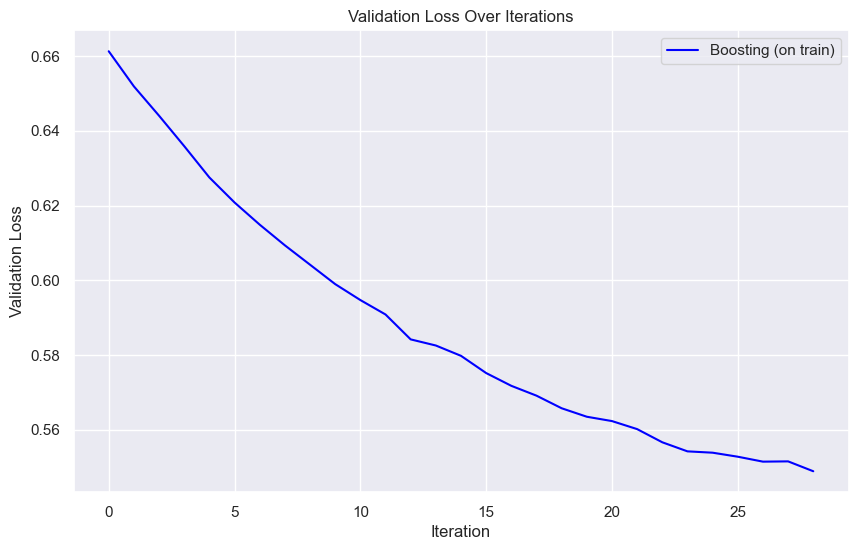

In [224]:
plt.figure(figsize=(10, 6))
plt.plot(best_trial.user_attrs['train_loss_history'], label="Boosting (on train)", color="blue")
#plt.plot(best_trial_lgb.user_attrs['val_roc_auc_history'], label="Boosting (on valid)", color="orange")
plt.title("Validation Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

<font color='plum'>**Вопрос:** Какая архитектура вам нравится больше всего и почему?</font>

<font color='plum'>**Ответ**: Очевидно та, с которой проще))
катбуст например меньше требует ручной настройки параметров, чем LightGBM, и при этом даёт приличные результаты, но мне интереснее показалось оставить вариант с LightGBM. Грустро правда, что нельзя встроенным образом историю вытащить, как в катбусте. А вообще с прунером все приятнее оказалось </font>

### Бонус. Random Forest (0.5 балла)

Если очень захотеть, оптуна может оптимизировать все, что угодно, даже нейросети. Давайте противопоставим бустингу его злейшего врага — алгоритм Random Forest.

Возьмите реализацию случайного леса из <font color='lightgreen'>`lightgbm`</font>. Посмотрите, какие там есть гиперпараметры, переберите что-либо из них вместе с `max_depth` и `n_estimators`.

Сравните его качество и динамику функции потерь (на обучающей и на валидационной выборке) с таковыми у бустинга и сделайте вывод, а нужен ли Random Forest?

In [192]:
def lgb_rf_objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "rf", 
        "n_jobs": -1,
        "num_leaves": trial.suggest_int("num_leaves", 7, 128),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": 1,  
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
    }
    num_boost_round = trial.suggest_int("n_estimators", 50, 500)

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    train_history_list = []
    valid_history_list = []
    
    def history_callback(env):
        train_history_list.append(env.evaluation_result_list[0][2])
        valid_history_list.append(env.evaluation_result_list[1][2])
        
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc", valid_name="valid")

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=["train","valid"],
        num_boost_round=num_boost_round,
        callbacks=[pruning_callback]
    )

    val_preds = model.predict(X_valid)
    val_auc = roc_auc_score(y_valid, val_preds)

    trial.set_user_attr("rf_train_auc_history", train_history_list)
    trial.set_user_attr("rf_valid_auc_history", valid_history_list)

    return val_auc


study_rf = optuna.create_study(
    study_name="lgb_random_forest_opt",
    storage="sqlite:///my_lgb_rf.db",
    load_if_exists=True,
    direction="maximize",
    pruner=MedianPruner(n_warmup_steps=5)
)

study_rf.optimize(lgb_rf_objective, n_trials=30)

[I 2024-12-22 21:59:13,704] Using an existing study with name 'lgb_random_forest_opt' instead of creating a new one.
[I 2024-12-22 21:59:14,144] Trial 2 finished with value: 0.9358170642056842 and parameters: {'num_leaves': 57, 'max_depth': 6, 'bagging_fraction': 0.6247044433856651, 'feature_fraction': 0.7147491722834275, 'n_estimators': 57}. Best is trial 2 with value: 0.9358170642056842.
[I 2024-12-22 21:59:16,837] Trial 3 finished with value: 0.9401723932878524 and parameters: {'num_leaves': 69, 'max_depth': 13, 'bagging_fraction': 0.7028343926249307, 'feature_fraction': 0.5552964104487599, 'n_estimators': 309}. Best is trial 3 with value: 0.9401723932878524.
[I 2024-12-22 21:59:20,432] Trial 4 finished with value: 0.9307242066580304 and parameters: {'num_leaves': 38, 'max_depth': 5, 'bagging_fraction': 0.6053758010262125, 'feature_fraction': 0.8909663877572721, 'n_estimators': 495}. Best is trial 3 with value: 0.9401723932878524.
[I 2024-12-22 21:59:21,103] Trial 5 finished with va

In [193]:
print("Best trial RandomForest (LightGBM):")
best_trial_rf = study_rf.best_trial
print(f"Value: {best_trial_rf.value}")
print("Params:")
for key, value in best_trial_rf.params.items():
    print(f"    {key}: {value}") 

Best trial RandomForest (LightGBM):
Value: 0.9414451088054036
Params:
    num_leaves: 109
    max_depth: 12
    bagging_fraction: 0.828406557172647
    feature_fraction: 0.7057374386198279
    n_estimators: 52


Справедливости ради результат получился лучше не на случайном лесе, что в целом ожидаемо. В контексте нашей задачи лучше без него (но вообще много где полезным бывает)

### 3.4. Бустинг и вероятности (0.5 балла)

С качеством мы более-менее разобрались, но что насчет вероятностей? Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности?

In [179]:
#взяла реализацию из дз 4
def plot_calibration_curve(y_test, preds, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)  
        bin_data = np.mean(y_test[(preds >= l) & (preds < r)] == 1)
        bin_real_ratios.append(bin_data)

    diag = np.linspace(0, 1, 100)
    plt.plot(diag, diag, linestyle="dashed")
    plt.plot(bin_middle_points, bin_real_ratios, label=label, linestyle="solid")
    plt.ylim([-0.05, 1.05])
    plt.grid()

In [171]:
best = Boosting(n_estimators=study.best_trial.params["n_estimators"],
                learning_rate=study.best_trial.params["learning_rate"],
                subsample=study.best_trial.params["subsample"],
                early_stopping_rounds=study.best_trial.params["early_stopping_rounds"],
                eval_set = (X_valid, y_valid),
                base_model_params= {
                    'max_depth': study.best_trial.params['max_depth'],
                    'min_samples_split': study.best_trial.params['tree_min_samples_split']
                })

best_boosting.fit(X_train, y_train)

Early stopping after 8 iterations.


In [226]:
from sklearn.linear_model import LogisticRegression

boosting_pred = best_boosting.predict_proba(X_test)[:, 1]

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

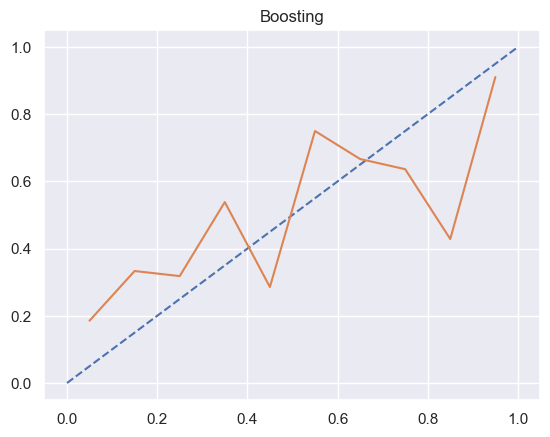

In [227]:
plot_calibration_curve(y_test, boosting_pred, label="Boosting")
plt.title("Boosting")
plt.grid()
plt.show()


Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

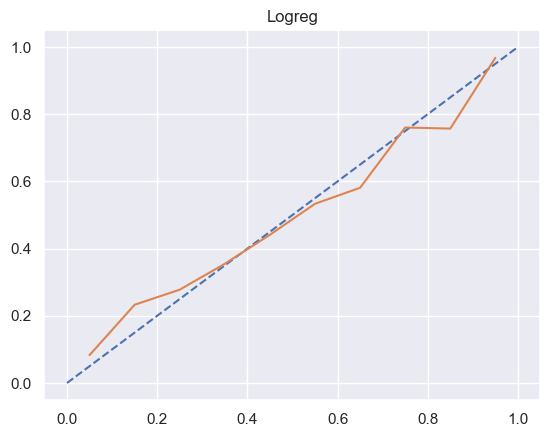

In [228]:
plot_calibration_curve(y_test, lr_pred, label="Logreg")
plt.title("Logreg")
plt.grid()
plt.show()

Кажется, что бустинг лучше SVM, но все еще значительно хуже логистической регресии - отклонения от идеальной калибровки получаются сильные. Получается, бустинг (по крайней мере, мой) не очень хорошо справляется с оценкой вероятностей

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2025 года?

# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

![picture](/Users/polinaryltseva/Downloads/IMG_0909.jpeg)

От нового года я жду сна, желательно даже с 25 числа (спасибо)

Желаю всего доброго и уютного проверяющим это в сессию! Сил